# GMM EM算法

In [3]:
import math
import numpy as np
from utils.metric import calculate_covariance_matrix,euclidean_distance

In [51]:
class GaussianMixtureModel():
    def __init__(self,k=3,max_iterations=400,tolerance=1e-8):
        self.k = k
        self.parameters = []
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.responsibilities = []
        self.sample_assignments = None
        self.responsibility = None
    def _init_random_gaussians(self, X):
        n_samples = np.shape(X)[0]
        self.priors = (1./self.k) * np.ones(self.k)
        for i in range(self.k):
            params = {}
            params['mean'] = X[np.random.choice(range(n_samples))]
            params["cov"] = calculate_covariance_matrix(X)
            self.parameters.append(params)
            
    # 计算多元高斯分布
    def multivariate_gaussian(self, X, params):
        n_features = np.shape(X)[1]
        mean = params["mean"]
        covar = params["cov"]
        determinant = np.linalg.det(covar)
        likelihoods = np.zeros(np.shape(X)[0])
        for i, sample in enumerate(X):
            d = n_features
            coeff = (1./(math.pow(2*math.pi,d/2)*math.sqrt(determinant)))
            exponent = math.exp(-0.5 * (sample - mean).T.dot(np.linalg.pinv(covar)).dot((sample - mean)))
            likelihoods[i] = coeff * exponent
        
        return likelihoods
    def _get_likelihoods(self, X):
        n_samples = np.shape(X)[0]
        likelihoods = np.zeros((n_samples, self.k))
        for i in range(self.k):
            likelihoods[:,i] = self.multivariate_gaussian(X,self.parameters[i])
        return likelihoods
    # E步
    def _expectation(self, X):
        weighted_likelihoods = self._get_likelihoods(X) * self.priors 
        sum_likelihoods = np.expand_dims(np.sum(weighted_likelihoods, axis=1), axis=1)
        self.responsibility = weighted_likelihoods / sum_likelihoods
        self.sample_assignments = self.responsibility.argmax(axis=1)
        self.responsibilities.append(np.max(self.responsibility, axis=1))
    # M步
    def _maximization(self, X):
        for i in range(self.k):
            resp = np.expand_dims(self.responsibility[:, i], axis=1)
            mean = (resp * X).sum(axis=0) / resp.sum()
            covariance = (X - mean).T.dot((X - mean) * resp) / resp.sum()
            self.parameters[i]["mean"], self.parameters[i]["cov"] = mean, covariance
        n_samples = np.shape(X)[0]
        self.priors = self.responsibility.sum(axis=0) / n_samples
            
    def _converged(self, X):
        if len(self.responsibilities) < 2:
            return False
        diff = np.linalg.norm(
            self.responsibilities[-1] - self.responsibilities[-2])
        return diff <= self.tolerance
    def predict(self,X):
        self._init_random_gaussians(X)
        for _ in range(self.max_iterations):
            self._expectation(X)
            self._maximization(X)
            if self._converged(X):
                break
        self._expectation(X)
        return self.sample_assignments

In [68]:
X = np.array([[ 0.697  ,0.46 ],
                         [ 0.774  ,0.376],
                         [ 0.634  ,0.264],
                         [ 0.608  ,0.318],
                         [ 0.556  ,0.215],
                         [ 0.403  ,0.237],
                         [ 0.481  ,0.149],
                         [ 0.437  ,0.211],
                         [ 0.666  ,0.091],
                         [ 0.243  ,0.267],
                         [ 0.245  ,0.057],
                         [ 0.343  ,0.099],
                         [ 0.639  ,0.161],
                         [ 0.657  ,0.198],
                         [ 0.36   ,0.37 ],
                         [ 0.593  ,0.042],
                         [ 0.719  ,0.103],
                         [ 0.359  ,0.188],
                         [ 0.339  ,0.241],
                         [ 0.282  ,0.257],
                         [ 0.748  ,0.232],
                         [ 0.714  ,0.346],
                         [ 0.483  ,0.312],
                         [ 0.478  ,0.437],
                         [ 0.525  ,0.369],
                         [ 0.751  ,0.489],
                         [ 0.532  ,0.472],
                         [ 0.473  ,0.376],
                         [ 0.725  ,0.445],
                         [ 0.446  ,0.459]])
clf = GaussianMixtureModel(k=3,max_iterations=10000,tolerance=1e-15)
res = clf.predict(X)

In [69]:
from matplotlib import pyplot as plt
%matplotlib inline

In [70]:
k0 = X[res==0]
k1 = X[res==1]
k2 = X[res==2]

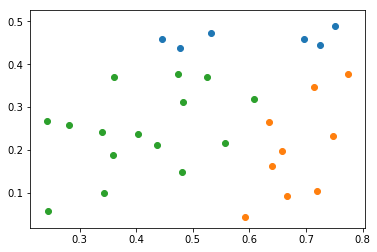

In [71]:
plt.scatter(k0[:,0],k0[:,1])
plt.scatter(k1[:,0],k1[:,1])
plt.scatter(k2[:,0],k2[:,1])